In [1]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel


import torch
# from torch import nn
import numpy as np

import pickle
from tqdm import tqdm


from collections import Counter
import matplotlib.pyplot as plt

import logging
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

I0228 15:45:27.833490 140301150287680 file_utils.py:38] PyTorch version 1.4.0 available.


## Load E-mail Data

In [2]:
with open("../../../w3c-emails/emails.pkl", "rb") as handle:
    emails = pickle.load(handle)

# Steps

 0. select authors (so that evaulation sets can be held out) and establish their frequencies <br>
   -> $P(X)$, i.e. the probability that a person appears as an author of any e-mail
 1. pre-train GPT-2 on W3C e-mail corpus <br> 
   -> W3CGPT-2 <br>
   -> approximates $P(email)$
 2. train W3CGPT-2 on e-mails by selected authors <br>
   -> GPT-2$_X$ for each person $X$ <br> 
   -> i.e. $P(email|X)$
 3. use GPT-2$_X$ to classify unseen (both to W3CGPT-2 and to GPT-2$_X$) e-mails <br>
   -> $P(X|email) = P(X)P(email|X)/P(email)$

## 0. Select Authors (and their e-mails)

 - author-frequency distribution Zipfian, so use log-linear ranks to select authors <br> 
   (i.e. author rank 1, author rank 2, author rank 4, author rank 8, ..., author rank 512)
   
 - plots below equivalent to $P(X)$

In [3]:
def select_by_ranks(emails, ls_of_ranks):
    sndr_cnts = Counter(e.sender for e in emails)
    ranks_sndr = {r:s for r, (s, c) in enumerate(sndr_cnts.most_common())}
    
    for r in ls_of_ranks:
        cur_s = ranks_sndr[r]
        yield [m for m in emails if m.sender == cur_s]
        
rank_rng = [2**i for i in range(10)]
selection = list(select_by_ranks(emails, rank_rng))
rest = list(set(emails) - set(m for m_ls in selection for m in m_ls))

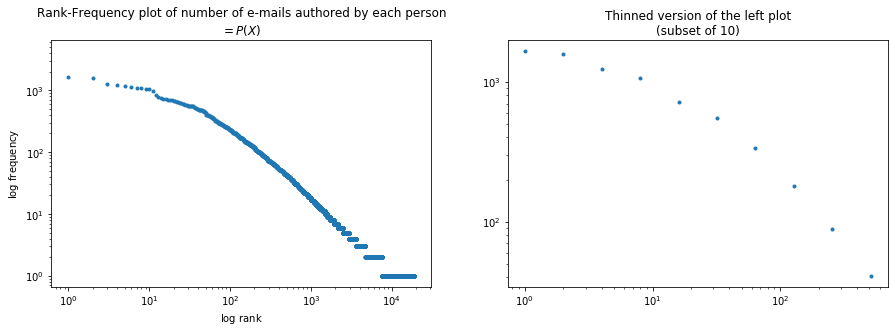

In [4]:
sndr_cnts = Counter(e.sender for e in emails)
rs, cs = list(zip(*[(r, c) for r, (_, c) in enumerate(sndr_cnts.most_common())]))

fig = plt.figure(1, figsize=(15, 10))
plt.subplot(221)
plt.loglog(rs, cs, '.')
plt.xlabel("$\log$ rank"); plt.ylabel("$\log$ frequency"); plt.title("Rank-Frequency plot of number of e-mails authored by each person\n$= P(X)$")

rng = [2**i for i in range(10)]
rng_cs = [cs[i] for i in rng]

plt.subplot(222)
plt.loglog(rng, rng_cs, '.')
_ = plt.title("Thinned version of the left plot\n(subset of 10)")

## 0.1 Get Train and Evaluation sets

using train:eval ratio of 30:70

In [16]:
perm = np.random.permutation
def split_train_test(ls, test_ratio=0.3):
    cutoff = int(len(ls)*test_ratio)
    randmsd_ls = list(perm(ls))
    test = randmsd_ls[:cutoff]
    train = randmsd_ls[cutoff:]
    
    return train, test

# def emails_to_datasets(selected, rest, test_ratio=0.3):
#     train, test = split_train_test(rest, test_ratio)
#     for mail_ls in selected:
#         cur_train, cur_test = split_train_test(mail_ls, test_ratio)
#         train.extend(cur_train)
#         test.extend(cur_test)
        
#     return train, test

selection_trains, selection_tests = list(zip(*[split_train_test(m_ls) for m_ls in selection]))
rest_train, rest_test = split_train_test(rest)

In [17]:
selection_never_seen, selection_tests2 = list(zip(*[split_train_test(m_ls, test_ratio=0.5) 
                                                   for m_ls in selection_tests]))
rest_never_seen, rest_test2 = split_train_test(rest_test, test_ratio=0.5)


print(list(map(len, selection_never_seen)), list(map(len, selection_tests2)))
len(rest_never_seen), len(rest_test)

[249, 239, 184, 161, 107, 83, 51, 27, 13, 6] [248, 239, 184, 161, 107, 82, 50, 26, 13, 6]


(20474, 40948)

## 1. Domain-Adapt GPT-2 to W3C E-mails

 - pre-train an instance of GPT-2 on entire (subset of) w3c-email corpus <br>
   -> will reduce perplexity and thus increase sensitivity of LMs
 - use this LM as starting point to train personalised LMs 
 - also reserve a test set? -> i.e. some e-mails which no custom-trained LM has seen before
 
 - => write e-mail bodies into text files, train and eval

In [19]:
def emails_to_trainfile(email_ls, file_name, split_into=1):
    chunk_size = len(email_ls)//split_into
    for i in range(split_into):
        with open(file_name + f".{i}", "w", encoding="utf-8") as handle:
            cur_chunk = email_ls[i*chunk_size:(i+1)*chunk_size] if i != split_into-1 else email_ls[i*chunk_size:]
            for m in cur_chunk:
                mail_str = m.body_raw.replace("\n", "  ")
                handle.write(mail_str)
                handle.write("\n\n")
            
full_train = perm(rest_train + 
                  [m for m_ls in selection_trains for m in m_ls] +
                  [m for m_ls in selection_tests2 for m in m_ls])

full_test = perm(rest_never_seen + [m for m_ls in selection_never_seen for m in m_ls])

emails_to_trainfile(full_train, "W3CGPT2/full.train.raw", split_into=5)
emails_to_trainfile(full_test, "W3CGPT2/full.test.raw", split_into=4)


### 1.1 Call for Training

  - first: merge split up text files -> `cat full.train.raw.* > full.train.raw.all`

`python3 run_language_modeling.py --train_data_file=W3CGPT2/full.train.raw.all --model_type=gpt2 --output_dir=W3CGPT2/lm --model_name_or_path=gpt2 --do_train --line_by_line --num_train_epochs=2`

 - `--line_by_line` indicates one sample per line to spearate e-mails, `"\n"` inside e-mails converted to `" "`
 - perhaps use `--block_size=128/256/512` (rather than GPT-2's default of 1024) -> loose fewer tokens at the ends of long emails
 
 
### 1.2 Load Trained

should be as simple as:

In [ ]:
model = GPT2Model.from_pretrained('/W3CGPT2/lm/') 

## 2. Train one instance of W3CGPT-2 per author $X$ to become GPT-2$_X$

 - load W3CGPT2
 - get training files
 - call `run_language_modeling.py` with adequate parameters
 - run on LISA

### 2.1 Training files, one per author

In [ ]:
for mail_ls in selection_trains: